# Computing spectroscopic completeness 

Jaime E. Forero-Romero, April 2022.

Nearing one year after the main DESI survey started, there are regions in the footprint that
have already been observed at full depth. In this notebook we will compute the spectroscopic completenes on one of such regions covering 135 squared degrees, i.e., 1% of the full survey, approximately.

We start by defining first the sky region of interest to then find the tiles that have been observed on that region. With that information we read the corresponding input targets, fiberassign outputs, redrock outputs and zmtl files. With those files at hand, we can finally compute the spectroscopic completeness

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import os
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.targetmask import obsmask, obsconditions, zwarn_mask
from astropy.table import Table
import desimodel.focalplane
plt.style.use('../mpl/desi.mplstyle')

Depending on the survey program that we want to inspect (either `maindark` or `mainbright`)
we define the boudaries of the regions where the completeness will be computed.
The regions we define here have been observed at full depth.
Why those boundaries in particular? See the thread started by David Schlegel on [desi-survey 3694]

Check by yourself what happens if we change `faflavor=maindark` to `faflavor=mainbright`

In [2]:
faflavor = 'maindark'

if faflavor == 'maindark':
    min_ra = 129.0
    min_dec = -6.0
    max_ra = 149.0
    max_dec = 1
    buffer = 2.0
elif faflavor == 'mainbright':
    min_ra = 129.0
    min_dec = -6.0
    max_ra = 146.0
    max_dec = 2
    buffer = 2.0

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 139.78 sqdeg


We now read the list of all tiles that have been observed so far.
We keep the tiles that have their centers within the region of interest plus an additional buffer of two degrees.

In [3]:
observed_tiles = Table.read("/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-specstatus.ecsv")

ii = (observed_tiles['FAFLAVOR'] == faflavor) & (observed_tiles['ZDONE']=='true')
ii &= observed_tiles['TILERA']>(min_ra-buffer)
ii &= observed_tiles['TILERA']<(max_ra+buffer)
ii &= observed_tiles['TILEDEC']>(min_dec-buffer)
ii &= observed_tiles['TILEDEC']<(max_dec+buffer)

observed_tiles = observed_tiles[ii]

In [4]:
observed_tiles

TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,ZDONE,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,QA,USER,OVERRIDE,QANIGHT,ARCHIVEDATE
int64,str7,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,str5,float64,float64,float64,float64,str7,float64,int64,str6,str19,int64,int64,int64
2514,main,dark,maindark,2,2667.9,145.802,1.84,1002.8,1046.9,842.9,1000.0,obsend,true,1046.9,1086.9,1009.5,720.1,dark,0.85,20220326,good,rongpu,0,20220326,20220328
2517,main,dark,maindark,1,1411.2,142.496,2.309,1006.4,985.0,848.1,1000.0,obsend,true,985.0,1078.9,914.6,764.7,dark,0.85,20220226,good,AJR,0,20220226,20220228
2519,main,dark,maindark,1,855.0,143.749,-0.791,1004.6,890.6,967.3,1000.0,obsend,true,890.6,948.9,851.0,1208.1,dark,0.85,20211211,good,adamyers,0,20211211,20211214
2520,main,dark,maindark,2,1888.3,147.055,-1.253,1007.7,934.3,999.2,1000.0,obsend,true,934.3,975.3,919.1,888.2,dark,0.85,20220131,good,rongpu,0,20220131,20220201
2521,main,dark,maindark,2,1891.4,149.126,1.365,1002.5,933.1,992.0,1000.0,obsend,true,933.1,967.5,923.2,990.0,dark,0.85,20220325,good,rongpu,0,20220325,20220328
2526,main,dark,maindark,3,3854.0,140.444,-0.324,1008.1,1004.8,0.0,1000.0,obsend,true,1004.8,1034.5,1029.0,1669.7,dark,0.85,20211212,good,sgontcho,0,20211212,20211214
2527,main,dark,maindark,1,1449.2,137.138,0.133,1005.7,1029.8,969.2,1000.0,obsend,true,1029.8,1058.4,999.2,1112.2,dark,0.85,20220130,good,rongpu,0,20220130,20220201
2529,main,dark,maindark,1,855.6,133.737,0.65,1005.4,939.0,909.6,1000.0,obsend,true,939.0,993.0,887.1,1221.1,dark,0.85,20220103,good,AJR,0,20220103,20220112
2530,main,dark,maindark,1,1042.1,135.008,-2.436,1004.4,927.6,950.9,1000.0,obsend,true,927.6,938.9,917.1,1286.8,dark,0.85,20211130,good,rongpu,0,20211130,20211201


We now plot the tiles before reading all the files that we need

(-6.0, 1.0)

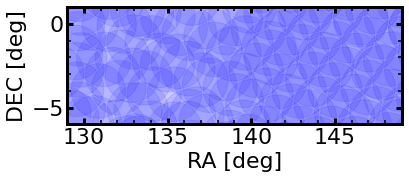

In [5]:
def plot_sky_circle(x, y, radius, alpha=0.2, color='blue'):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = x + np.cos(np.radians(y))*radius*np.cos(theta)
    yy = y + radius*np.sin(theta)
    plt.fill(xx, yy, alpha=alpha, color=color)

def plot_tiles(tiles_ra, tiles_dec):
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    for i in range(len(tiles_ra)):
        plot_sky_circle(tiles_ra[i], tiles_dec[i], tile_radius, color='blue', alpha=0.1)
    
plot_tiles(observed_tiles['TILERA'], observed_tiles['TILEDEC'])
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.axis('scaled')
plt.xlim(min_ra, max_ra)
plt.ylim(min_dec, max_dec)

Now we read, tile by tile, the files corresponding to: 
- the input targets (`-targ.fits`) to know the original input target catalog to that tile.
- the redrock files (`redrock-*-*thru*.fits`) to know what was available to a fiber and what actually got a fiber.
- the zmtl files (`redrock-*-*thru*.fits`) to know what is considered to have a good redshift. 

The redrock files and the zmtl tiles are read individually for each petal. It is entirely possible
that some of those petal files do not exist because they were discarded at the time of data processing.
We include a warning to find out if that happens at all.

In [6]:
z = []
fba = []
exp_fba = []
target = []
zmtl = []

main_path = "/global/cfs/cdirs/desi/spectro/redux/daily/tiles/archive/"
for i in range(len(observed_tiles)):
    tileid = observed_tiles['TILEID'][i]
    lastnight = observed_tiles['LASTNIGHT'][i]
    archive = observed_tiles['ARCHIVEDATE'][i]
    rr_path = os.path.join(main_path, 
                        "{}".format(tileid), "{}".format(archive))
    target_path = os.path.join("/global/cfs/cdirs/desi/survey/fiberassign/main/",
                              "{:03d}".format(tileid//1000))
    # gather all targets
    try:
        target_file = os.path.join(target_path, "{:06d}-targ.fits".format(tileid))
        target.append(fitsio.read(target_file))
    except:
        print("failed for targets in tile {}".format(tileid))
    
    # gather all redrock outputs
    for petal in range(10):
        redrock_file = os.path.join(rr_path, "redrock-{}-{}-thru{}.fits".format(petal, tileid, lastnight))
        try:
            z.append(fitsio.read(redrock_file, ext="REDSHIFTS")) # redshifts given by redrock
            fba.append(fitsio.read(redrock_file, ext="FIBERMAP")) # information from the original fiberassign design
            exp_fba.append(fitsio.read(redrock_file, ext="EXP_FIBERMAP")) # information from the actual exposure.
        except:
            print("failed for redrock file from petal {}, tileid {} and night {}".format(petal, tileid, lastnight))
            
    # gather all zmtl outputs
    for petal in range(10):
        zmtl_file = os.path.join(rr_path, "zmtl-{}-{}-thru{}.fits".format(petal, tileid, lastnight))
        try:
            petal_zmtl = fitsio.read(zmtl_file, ext="ZMTL")
            bad = petal_zmtl["ZWARN"] & zwarn_mask.mask("NODATA|BAD_SPECQA|BAD_PETALQA") != 0 # this is our definition of a bad redshift.
            petal_zmtl = petal_zmtl[~bad]
            zmtl.append(petal_zmtl)
        except:
            print("failed for zmtl file from petal {}, tileid {} and night {}".format(petal, tileid, lastnight))
        
data_z = np.hstack(z)
data_fba = np.hstack(fba)
data_exp_fba = np.hstack(exp_fba)
data_target = np.hstack(target)
data_zmtl = np.hstack(zmtl)

failed for redrock file from petal 7, tileid 8776 and night 20220104
failed for zmtl file from petal 7, tileid 8776 and night 20220104
failed for redrock file from petal 7, tileid 8777 and night 20220104
failed for zmtl file from petal 7, tileid 8777 and night 20220104


We have overlapping tiles. That means that we have repeated targets in the arrays we have just built. 
Furthermore, we also have targets in the buffer region that should not be counted.

In the following lines we discard repeated targets and drop the targets in the buffer region.

In [7]:
# unique target ids
_, unique_ii = np.unique(data_target['TARGETID'], return_index=True)
data_target = data_target[unique_ii]

# targets inside the region of interest
ii = data_target['RA']>(min_ra)
ii &= data_target['RA']<(max_ra)
ii &= data_target['DEC']>(min_dec)
ii &= data_target['DEC']<(max_dec)
data_target = data_target[ii]

# keep only the unique matching targets in the other files
ii = np.isin(data_fba['TARGETID'], data_target['TARGETID'])
data_fba = data_fba[ii]
_, unique_ii = np.unique(data_fba['TARGETID'], return_index=True)
data_fba = data_fba[unique_ii]

ii = np.isin(data_exp_fba['TARGETID'], data_target['TARGETID'])
data_exp_fba = data_exp_fba[ii]
_, unique_ii = np.unique(data_exp_fba['TARGETID'], return_index=True)
data_exp_fba = data_exp_fba[unique_ii]

ii = np.isin(data_zmtl['TARGETID'], data_target['TARGETID'])
data_zmtl = data_zmtl[ii]
_, unique_ii = np.unique(data_zmtl['TARGETID'], return_index=True)
data_zmtl = data_zmtl[unique_ii]

(-6.0, 1.0)

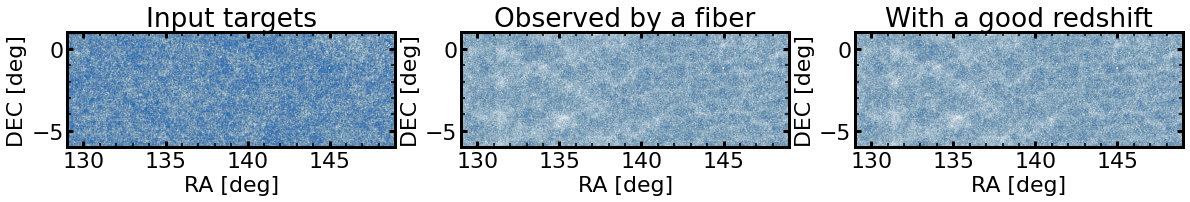

In [8]:
plt.figure(figsize=(20,11))
plt.subplot(1,3,1)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.axis('scaled')
plt.title('Input targets')
plt.scatter(data_target['RA'], data_target['DEC'], s=0.05, alpha=0.1)
plt.xlim(min_ra, max_ra)
plt.ylim(min_dec, max_dec)


plt.subplot(1,3,2)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.axis('scaled')
plt.title('Observed by a fiber')
plt.scatter(data_exp_fba['FIBER_RA'], data_exp_fba['FIBER_DEC'], s=0.05, alpha=0.1)
plt.xlim(min_ra, max_ra)
plt.ylim(min_dec, max_dec)

plt.subplot(1,3,3)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.axis('scaled')
plt.title('With a good redshift')
ii_z = np.isin(data_target['TARGETID'], data_zmtl['TARGETID'])
plt.scatter(data_target['RA'][ii_z], data_target['DEC'][ii_z], s=0.05, alpha=0.1)
plt.xlim(min_ra, max_ra)
plt.ylim(min_dec, max_dec)

We now define the specific target classes for which we want to compute its efficiency

In [9]:
if faflavor == 'mainbright':
    targets = ['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_HIP', 'BGS_WISE', 'MWS_ANY']
    mask = bgs_mask
    target_mask = 'BGS_TARGET'
    
elif faflavor == 'maindark':
    targets = ['LRG','ELG','QSO','ELG_HIP','ELG_LOP','ELG_VLO','MWS_ANY']
    mask = desi_mask
    target_mask = 'DESI_TARGET'

format_data = '{}\t\t{:.0f}\t {:.0f}\t {:.0f}\t {:.0f}\t\t{:.3f}\t {:.3f}'
format_header = '{}\t\t{}\t {}\t {}\t {}\t{}\t {}'.format('TARGET', 'NOBJ', 'NOBS', 'NGOODZ', 'DENS(OBJ)', 'FOBS', 'FGOODZ')

In [10]:
print(format_header)
for t in targets:
    if t=='MWS_ANY' and faflavor=='mainbright':
        mask = desi_mask
        target_mask = 'DESI_TARGET'
        
    #is a target of interest
    is_target = (data_target[target_mask] & mask[t])!=0
    
    #got a fiber
    is_fba = np.isin(data_exp_fba['TARGETID'], data_target['TARGETID'][is_target])
    
    #got a good redshift
    is_z = np.isin(data_zmtl['TARGETID'], data_target['TARGETID'][is_target])
    
    n_target = np.count_nonzero(is_target) 
    n_in_fba = np.count_nonzero(is_fba)
    n_with_z = np.count_nonzero(is_z)
    
    print(format_data.format(t, n_target, n_in_fba, n_with_z, 
                             n_target/area, n_in_fba/n_target, n_with_z/n_target))

TARGET		NOBJ	 NOBS	 NGOODZ	 DENS(OBJ)	FOBS	 FGOODZ
LRG		87417	 79052	 78846	 625		0.904	 0.902
ELG		327268	 213461	 212140	 2341		0.652	 0.648
QSO		39410	 39252	 39228	 282		0.996	 0.995
ELG_HIP		32726	 30406	 30331	 234		0.929	 0.927
ELG_LOP		262078	 185346	 184288	 1875		0.707	 0.703
ELG_VLO		65190	 28115	 27852	 466		0.431	 0.427
MWS_ANY		16631	 7207	 7118	 119		0.433	 0.428
